# <center>First Update on Group Project
# <center>Safe Trade: Stock Prediction
Shofiqur Rahman<br>
Bashir Ahamed<br>
Michelle Uy<br>
Thierno Diallo<br><br>
Grant Long<br>
CSC.59970<br>
November 05, 2018</p>

With a lot of company stocks listed and a huge amount of trading done each working day we have an immense amoount of data at our hand. With that a problem comes is what we consider and what we discard as not necessary. Most importantly, what features do really impact stock prices. The first task is to come up with some features that effects stock prices. For that purpose, we will see correlation between stock price and each features we can find. The data will come from [IEX API](https://iextrading.com/developer/docs/)

Also with all the varieties of stock data at hand we realize that dealing with all the different company stocks together might not give us a woriking model for all company; a model appropriate to predict on one company stocks might not perform equally well on another company. So, initially our foucs is on to build a model that can predict well at least for a company, namely Apple Inc. or AAPL.

We also realize that pridicting an exact stock price depending on some regression model might be too bold. Instead, what we could do is to say, given the present state of the market, if the company stock price is going to rise or fall in near future (Probably, to be specific, in next three/four months). We might add to that by what percent the stock might rise. 

In [16]:
# Import necessary python modules to equip ourselves with better tools

# Import library for data manipulation
import pandas as pd
# Import pyhton http library
import requests
# To work with JSON objects returned from http calls
import json

# To get training and test data
from sklearn.model_selection import train_test_split
# To get the visualization tolls
import matplotlib.pyplot as plt


In [17]:
# All API calls to IEX is prefixed with this
iexUrl = 'https://api.iextrading.com/1.0'

# Testing: Making API call to see current price
response = requests.get(iexUrl + '/stock/GOOG/price')
print('API Call Success! \n Google Price: ' + response.text)

API Call Success! 
 Google Price: 1066.15


In [18]:
# Declaring the main dataframe that we will be manipulating throughout the model building
df = pd.DataFrame(columns=['date', 'company', 'symbol', 'dividend', 'eps', 'grossProfit', 'marketcap', 'pe', 'price', 'revenuePerShare'])


In [19]:
### Populating df with data for Apple Inc.
tempdf = pd.DataFrame(columns=['date', 'company', 'symbol', 'dividend', 'eps', 'grossProfit', 'marketcap', 'pe', 'price', 'revenuePerShare'])

# Making API call to get last one year end of day close price(target value) and transaction date for AAPL
response = requests.get(iexUrl + '/stock/aapl/chart/1y')
JSONdata = response.json()
date = list()
price = list()
for data in JSONdata:
    date.append(data['date'])
    price.append(data['close'])
tempdf.date = date
tempdf.price = price
tempdf.company = 'Apple Inc.'
tempdf.symbol = 'AAPL'

In [20]:
# Making API call to get last one year querterly EPS
response = requests.get(iexUrl + '/stock/aapl/earnings')
JSONdata = response.json()
totalEPS = 0 # to set the null EPS later

# Setting EPS values for transaction days that happened after the EPS reporting date
for data in JSONdata['earnings']:
    tempdf.loc[tempdf['date'] > data['EPSReportDate'], ['eps']] = data['actualEPS']
    totalEPS += data['actualEPS']
    
# Setting NaN values in EPS to avarage of last four EPS
tempdf.loc[pd.isnull(tempdf['eps']), ['eps']] = totalEPS / len(JSONdata['earnings'])


In [21]:
# Calculating pe
tempdf['pe'] = tempdf['price'] / tempdf['eps']


In [22]:
# Making API call to get last one year querterly dividends
response = requests.get(iexUrl + '/stock/aapl/dividends/1y')
JSONdata = response.json()
totalDividend = 0 # to set the null dividend later

# Setting dividend values for transaction days that happened after the dividend declaredDate
for data in JSONdata:
    tempdf.loc[tempdf['date'] > data['declaredDate'], ['dividend']] = data['amount']
    totalDividend += data['amount']
    
# Setting NaN values in dividend to avarage of last four dividend amount
tempdf.loc[pd.isnull(tempdf['dividend']), ['dividend']] = totalDividend / len(JSONdata)


In [23]:
# Making API call to get last one year marketcap and revenuePerShare
response = requests.get(iexUrl + '/stock/aapl/stats')
JSONdata = response.json()

tempdf['marketcap'] = JSONdata['marketcap']
tempdf['revenuePerShare'] = JSONdata['revenuePerShare']


In [24]:
# Making API call to get last one year grossProfit
response = requests.get(iexUrl + '/stock/aapl/financials?period=annual')
JSONdata = response.json()

totalgrossProfit = 0 # to set the null grossProfit later

# Setting grossProfit values for transaction days that happened after the grossProfit report date
for data in JSONdata['financials']:
    tempdf.loc[tempdf['date'] > data['reportDate'], ['grossProfit']] = data['grossProfit']
    totalgrossProfit += data['grossProfit']
    
# Setting NaN values in grossProfit to avarage of last four grossProfit
tempdf.loc[pd.isnull(tempdf['grossProfit']), ['grossProfit']] = totalgrossProfit / len(JSONdata['financials'])


In [26]:
# Concatenating Apple dataframe to the main dataframe df
df = pd.concat([df, tempdf], ignore_index=True)


In [27]:
# Save all stock data in a CSV file called 'StockData.csv'
df.to_csv('StockData.csv')


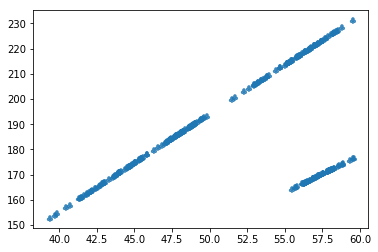

In [28]:
# Visualizig correlation between stock price and pe 
plt.scatter(df.pe, df.price, alpha=0.5, marker=r'$\clubsuit$')
plt.show()


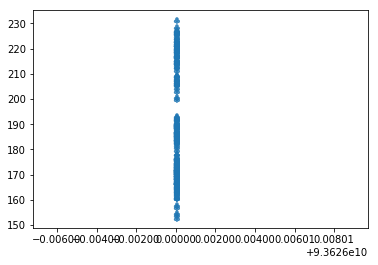

In [29]:
# Visualizig correlation between stock price and pe 
plt.scatter(df.grossProfit, df.price, alpha=0.5, marker=r'$\clubsuit$')
plt.show()

In [30]:
### Divide the DataFrame in X(Features) and Y(Target)
X = df[['dividend', 'eps', 'grossProfit', 'marketcap', 'pe', 'revenuePerShare']].copy()
Y = df.price

In [51]:
# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split
# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor
# Import accuracy_score
from sklearn.metrics import accuracy_score
# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# min_samples_leaf tell the model to keep at least 10% data for each leaf
#SEED = 3
#dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=0.1, random_state=SEED)

# Fit dt to the training set
#dt.fit(X_train, y_train)

# Predict test set labels
#y_pred = dt.predict(X_test)
#print(y_pred[0:5])

# Compute test set accuracy: applicable only for classification model?
#acc = accuracy_score(y_test, y_pred)
#print("Test set accuracy: {:.2f}".format(acc))


In [63]:
# Instantiate dt
# min_samples_leaf tell the model to keep at least 10% data for each leaf
lr = DecisionTreeRegressor(max_depth=8,
             min_samples_leaf=0.1,
            random_state=3)

# Fit dt to the training set
lr.fit(X_train, y_train)

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

# Compare Linear Regression with Logistic Regression
# Predict test set labels 
y_pred_lr = lr.predict(X_test)

# Compute mse_lr
mse_lr = MSE(y_test, y_pred_lr)

# Compute rmse_lr
rmse_lr = mse_lr**(1/2)

# Print rmse_lr
print('Linear Regression test set RMSE: {:.2f}'.format(rmse_lr))

# Print rmse_dt
print('Regression Tree test set RMSE: {:.2f}'.format(rmse_dt))


Test set RMSE of dt: 3.35
Linear Regression test set RMSE: 3.35
Regression Tree test set RMSE: 3.35


In [64]:
# The Generalization error tells us how much it generalizes on unseen data
# bias=underfitting and variance=overfitting

In [71]:
from sklearn.model_selection import cross_val_score

# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, X_train, y_train, cv=10, 
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict the labels of the training set
y_pred_train = dt.predict(X_train)

# Evaluate the training set RMSE of dt
RMSE_train = (mean_squared_error(y_train, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x1039426f0, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1039426f0, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(15, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(15, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (15, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=15, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.model_selection import cross_val_sc...n\nprint('Train RMSE: {:.2f}'.format(RMSE_train))\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 11, 7, 7, 4, 672553, tzinfo=tzutc()), 'msg_id': '842a111edb38416887fa940c452ebdc0', 'msg_type': 'execute_request', 'session': 'c2236555c98043e0843b91f09fd2e05f', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '842a111edb38416887fa940c452ebdc0', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'c2236555c98043e0843b91f09fd2e05f']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.model_selection import cross_val_sc...n\nprint('Train RMSE: {:.2f}'.format(RMSE_train))\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 11, 7, 7, 4, 672553, tzinfo=tzutc()), 'msg_id': '842a111edb38416887fa940c452ebdc0', 'msg_type': 'execute_request', 'session': 'c2236555c98043e0843b91f09fd2e05f', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '842a111edb38416887fa940c452ebdc0', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'c2236555c98043e0843b91f09fd2e05f'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "from sklearn.model_selection import cross_val_sc...n\nprint('Train RMSE: {:.2f}'.format(RMSE_train))\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 11, 7, 7, 4, 672553, tzinfo=tzutc()), 'msg_id': '842a111edb38416887fa940c452ebdc0', 'msg_type': 'execute_request', 'session': 'c2236555c98043e0843b91f09fd2e05f', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '842a111edb38416887fa940c452ebdc0', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="from sklearn.model_selection import cross_val_sc...n\nprint('Train RMSE: {:.2f}'.format(RMSE_train))\n", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "from sklearn.model_selection import cross_val_sc...n\nprint('Train RMSE: {:.2f}'.format(RMSE_train))\n"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("from sklearn.model_selection import cross_val_sc...n\nprint('Train RMSE: {:.2f}'.format(RMSE_train))\n",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("from sklearn.model_selection import cross_val_sc...n\nprint('Train RMSE: {:.2f}'.format(RMSE_train))\n",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from sklearn.model_selection import cross_val_sc...n\nprint('Train RMSE: {:.2f}'.format(RMSE_train))\n", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "from sklearn.model_selection import cross_val_sc...n\nprint('Train RMSE: {:.2f}'.format(RMSE_train))\n"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="from sklearn.model_selection import cross_val_sc...n\nprint('Train RMSE: {:.2f}'.format(RMSE_train))\n", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.ImportFrom object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-71-371adeafe5e1>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1a17dc9748, execution...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1a17c84ed0, file "<ipython-input-71-371adeafe5e1>", line 4>
        result = <ExecutionResult object at 1a17dc9748, execution...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1a17c84ed0, file "<ipython-input-71-371adeafe5e1>", line 4>, result=<ExecutionResult object at 1a17dc9748, execution...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1a17c84ed0, file "<ipython-input-71-371adeafe5e1>", line 4>
        self.user_global_ns = {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'In': ['', '# Import necessary python modules to equip ourse...sualization tolls\nimport matplotlib.pyplot as plt', "# All API calls to IEX is prefixed with this\niex...Call Success! \\n Google Price: ' + response.text)", "# Declaring the main dataframe that we will be m..., 'marketcap', 'pe', 'price', 'revenuePerShare'])", "### Populating df with data for Apple Inc.\ntempd...pdf.company = 'Apple Inc.'\ntempdf.symbol = 'AAPL'", "# Making API call to get last one year querterly..., ['eps']] = totalEPS / len(JSONdata['earnings'])", "# Calculating pe\ntempdf['pe'] = tempdf['price'] / tempdf['eps']", "# Making API call to get last one year querterly...]), ['dividend']] = totalDividend / len(JSONdata)", "# Making API call to get last one year marketcap...['revenuePerShare'] = JSONdata['revenuePerShare']", "# Making API call to get last one year grossProf... = totalgrossProfit / len(JSONdata['financials'])", '# To concate another company with dataframe df\nd...concat([df, tempdf], ignore_index=True)\ndf.head()', "# Save all stock data in a CSV file called 'StockData.csv'\ndf.to_csv('StockData.csv')", "# Visualizig correlation between stock price and...ice, alpha=0.5, marker=r'$\\clubsuit$')\nplt.show()", "# Visualizig correlation between stock price and...ice, alpha=0.5, marker=r'$\\clubsuit$')\nplt.show()", "# Import RandomForestRegressor\nfrom sklearn.ense...en')\nplt.title('Features Importances')\nplt.show()", "### Divide the DataFrame in X and Y\nX = df[['div...p', 'pe', 'revenuePerShare']].copy()\nY = df.price", '# Import necessary python modules to equip ourse...sualization tolls\nimport matplotlib.pyplot as plt', "# All API calls to IEX is prefixed with this\niex...Call Success! \\n Google Price: ' + response.text)", "# Declaring the main dataframe that we will be m..., 'marketcap', 'pe', 'price', 'revenuePerShare'])", "### Populating df with data for Apple Inc.\ntempd...pdf.company = 'Apple Inc.'\ntempdf.symbol = 'AAPL'", ...], 'JSONdata': {'financials': [{'cashChange': 5624000000, 'cashFlow': 77434000000, 'costOfRevenue': 163756000000, 'currentAssets': 131339000000, 'currentCash': 25913000000, 'currentDebt': 20748000000, 'grossProfit': 101839000000, 'netIncome': 59531000000, 'operatingExpense': 30941000000, 'operatingGainsLosses': None, ...}, {'cashChange': -195000000, 'cashFlow': 63598000000, 'costOfRevenue': 141048000000, 'currentAssets': 128645000000, 'currentCash': 20289000000, 'currentDebt': 18473000000, 'grossProfit': 88186000000, 'netIncome': 48351000000, 'operatingExpense': 26842000000, 'operatingGainsLosses': None, ...}, {'cashChange': -636000000, 'cashFlow': 65824000000, 'costOfRevenue': 131376000000, 'currentAssets': 106869000000, 'currentCash': 20484000000, 'currentDebt': 11605000000, 'grossProfit': 84263000000, 'netIncome': 45687000000, 'operatingExpense': 24239000000, 'operatingGainsLosses': None, ...}, {'cashChange': 7276000000, 'cashFlow': 81266000000, 'costOfRevenue': 140089000000, 'currentAssets': 89378000000, 'currentCash': 21120000000, 'currentDebt': 10999000000, 'grossProfit': 93626000000, 'netIncome': 53394000000, 'operatingExpense': 22396000000, 'operatingGainsLosses': None, ...}], 'symbol': 'AAPL'}, 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'MSE': <function mean_squared_error>, 'MSE_CV_scores': array([12.44504718,  7.07674923,  7.25929642,  7...4999063 ,  7.38345695,  5.49675608,  7.52317523]), 'Out': {10:          date     company symbol dividend     ep...      19  
4  56.1345  166.5791              19  , 25:          date     company symbol dividend     ep...      19  
4  56.1345  166.5791              19  , 41: DecisionTreeRegressor(criterion='mse', max_depth...  presort=False, random_state=1, splitter='best'), 43: DecisionTreeRegressor(criterion='mse', max_depth...  presort=False, random_state=1, splitter='best')}, 'RMSE_CV': 2.9426910744181263, ...}
        self.user_ns = {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'In': ['', '# Import necessary python modules to equip ourse...sualization tolls\nimport matplotlib.pyplot as plt', "# All API calls to IEX is prefixed with this\niex...Call Success! \\n Google Price: ' + response.text)", "# Declaring the main dataframe that we will be m..., 'marketcap', 'pe', 'price', 'revenuePerShare'])", "### Populating df with data for Apple Inc.\ntempd...pdf.company = 'Apple Inc.'\ntempdf.symbol = 'AAPL'", "# Making API call to get last one year querterly..., ['eps']] = totalEPS / len(JSONdata['earnings'])", "# Calculating pe\ntempdf['pe'] = tempdf['price'] / tempdf['eps']", "# Making API call to get last one year querterly...]), ['dividend']] = totalDividend / len(JSONdata)", "# Making API call to get last one year marketcap...['revenuePerShare'] = JSONdata['revenuePerShare']", "# Making API call to get last one year grossProf... = totalgrossProfit / len(JSONdata['financials'])", '# To concate another company with dataframe df\nd...concat([df, tempdf], ignore_index=True)\ndf.head()', "# Save all stock data in a CSV file called 'StockData.csv'\ndf.to_csv('StockData.csv')", "# Visualizig correlation between stock price and...ice, alpha=0.5, marker=r'$\\clubsuit$')\nplt.show()", "# Visualizig correlation between stock price and...ice, alpha=0.5, marker=r'$\\clubsuit$')\nplt.show()", "# Import RandomForestRegressor\nfrom sklearn.ense...en')\nplt.title('Features Importances')\nplt.show()", "### Divide the DataFrame in X and Y\nX = df[['div...p', 'pe', 'revenuePerShare']].copy()\nY = df.price", '# Import necessary python modules to equip ourse...sualization tolls\nimport matplotlib.pyplot as plt', "# All API calls to IEX is prefixed with this\niex...Call Success! \\n Google Price: ' + response.text)", "# Declaring the main dataframe that we will be m..., 'marketcap', 'pe', 'price', 'revenuePerShare'])", "### Populating df with data for Apple Inc.\ntempd...pdf.company = 'Apple Inc.'\ntempdf.symbol = 'AAPL'", ...], 'JSONdata': {'financials': [{'cashChange': 5624000000, 'cashFlow': 77434000000, 'costOfRevenue': 163756000000, 'currentAssets': 131339000000, 'currentCash': 25913000000, 'currentDebt': 20748000000, 'grossProfit': 101839000000, 'netIncome': 59531000000, 'operatingExpense': 30941000000, 'operatingGainsLosses': None, ...}, {'cashChange': -195000000, 'cashFlow': 63598000000, 'costOfRevenue': 141048000000, 'currentAssets': 128645000000, 'currentCash': 20289000000, 'currentDebt': 18473000000, 'grossProfit': 88186000000, 'netIncome': 48351000000, 'operatingExpense': 26842000000, 'operatingGainsLosses': None, ...}, {'cashChange': -636000000, 'cashFlow': 65824000000, 'costOfRevenue': 131376000000, 'currentAssets': 106869000000, 'currentCash': 20484000000, 'currentDebt': 11605000000, 'grossProfit': 84263000000, 'netIncome': 45687000000, 'operatingExpense': 24239000000, 'operatingGainsLosses': None, ...}, {'cashChange': 7276000000, 'cashFlow': 81266000000, 'costOfRevenue': 140089000000, 'currentAssets': 89378000000, 'currentCash': 21120000000, 'currentDebt': 10999000000, 'grossProfit': 93626000000, 'netIncome': 53394000000, 'operatingExpense': 22396000000, 'operatingGainsLosses': None, ...}], 'symbol': 'AAPL'}, 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'MSE': <function mean_squared_error>, 'MSE_CV_scores': array([12.44504718,  7.07674923,  7.25929642,  7...4999063 ,  7.38345695,  5.49675608,  7.52317523]), 'Out': {10:          date     company symbol dividend     ep...      19  
4  56.1345  166.5791              19  , 25:          date     company symbol dividend     ep...      19  
4  56.1345  166.5791              19  , 41: DecisionTreeRegressor(criterion='mse', max_depth...  presort=False, random_state=1, splitter='best'), 43: DecisionTreeRegressor(criterion='mse', max_depth...  presort=False, random_state=1, splitter='best')}, 'RMSE_CV': 2.9426910744181263, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/Users/shofi/Desktop/SafeTrade/<ipython-input-71-371adeafe5e1> in <module>()
      1 from sklearn.model_selection import cross_val_score
      2 
      3 # Compute the array containing the 10-folds CV MSEs
      4 MSE_CV_scores = - cross_val_score(dt, X_train, y_train, cv=10, 
      5                        scoring='neg_mean_squared_error',
----> 6                        n_jobs=-1)
      7 
      8 # Compute the 10-folds CV RMSE
      9 RMSE_CV = (MSE_CV_scores.mean())**(1/2)
     10 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=DecisionTreeClassifier(class_weight=None, criter...lse, random_state=1,
            splitter='best'), X=    dividend     eps   grossProfit     marketcap...  57.4459              19

[354 rows x 6 columns], y=13     166.9732
61     152.8551
377    187.9925
...170.4707
Name: price, Length: 354, dtype: float64, groups=None, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_validate(estimator=DecisionTreeClassifier(class_weight=None, criter...lse, random_state=1,
            splitter='best'), X=    dividend     eps   grossProfit     marketcap...  57.4459              19

[354 rows x 6 columns], y=13     166.9732
61     152.8551
377    187.9925
...170.4707
Name: price, Length: 354, dtype: float64, groups=None, scoring={'score': make_scorer(mean_squared_error, greater_is_better=False)}, cv=KFold(n_splits=10, random_state=None, shuffle=False), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=10, random_state=None, shuffle=False)>
        X =     dividend     eps   grossProfit     marketcap...  57.4459              19

[354 rows x 6 columns]
        y = 13     166.9732
61     152.8551
377    187.9925
...170.4707
Name: price, Length: 354, dtype: float64
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Nov 11 02:07:04 2018
PID: 4927                               Python 3.6.5: /anaconda3/bin/python
...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (DecisionTreeClassifier(class_weight=None, criter...lse, random_state=1,
            splitter='best'),     dividend     eps   grossProfit     marketcap...  57.4459              19

[354 rows x 6 columns], 13     166.9732
61     152.8551
377    187.9925
...170.4707
Name: price, Length: 354, dtype: float64, {'score': make_scorer(mean_squared_error, greater_is_better=False)}, array([ 36,  37,  38,  39,  40,  41,  42,  43,  ..., 346, 347,
       348, 349, 350, 351, 352, 353]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35]), 0, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (DecisionTreeClassifier(class_weight=None, criter...lse, random_state=1,
            splitter='best'),     dividend     eps   grossProfit     marketcap...  57.4459              19

[354 rows x 6 columns], 13     166.9732
61     152.8551
377    187.9925
...170.4707
Name: price, Length: 354, dtype: float64, {'score': make_scorer(mean_squared_error, greater_is_better=False)}, array([ 36,  37,  38,  39,  40,  41,  42,  43,  ..., 346, 347,
       348, 349, 350, 351, 352, 353]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35]), 0, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=DecisionTreeClassifier(class_weight=None, criter...lse, random_state=1,
            splitter='best'), X=    dividend     eps   grossProfit     marketcap...  57.4459              19

[354 rows x 6 columns], y=13     166.9732
61     152.8551
377    187.9925
...170.4707
Name: price, Length: 354, dtype: float64, scorer={'score': make_scorer(mean_squared_error, greater_is_better=False)}, train=array([ 36,  37,  38,  39,  40,  41,  42,  43,  ..., 346, 347,
       348, 349, 350, 351, 352, 353]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method DecisionTreeClassifier.fit of Deci...se, random_state=1,
            splitter='best')>
        X_train =     dividend     eps   grossProfit     marketcap...  57.4459              19

[318 rows x 6 columns]
        y_train = 59     160.6186
120    181.8494
12     170.5101
...170.4707
Name: price, Length: 318, dtype: float64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...lse, random_state=1,
            splitter='best'), X=    dividend     eps   grossProfit     marketcap...  57.4459              19

[318 rows x 6 columns], y=59     160.6186
120    181.8494
12     170.5101
...170.4707
Name: price, Length: 318, dtype: float64, sample_weight=None, check_input=True, X_idx_sorted=None)
    785 
    786         super(DecisionTreeClassifier, self).fit(
    787             X, y,
    788             sample_weight=sample_weight,
    789             check_input=check_input,
--> 790             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
    791         return self
    792 
    793     def predict_proba(self, X, check_input=True):
    794         """Predict class probabilities of the input samples X.

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...lse, random_state=1,
            splitter='best'), X=array([[6.3000000e-01, 3.8900001e+00, 9.3625999e...   5.7445896e+01, 1.9000000e+01]], dtype=float32), y=array([[160.6186],
       [181.8494],
       [17...192.1135],
       [220.4209],
       [170.4707]]), sample_weight=None, check_input=True, X_idx_sorted=None)
    135             y = np.reshape(y, (-1, 1))
    136 
    137         self.n_outputs_ = y.shape[1]
    138 
    139         if is_classification:
--> 140             check_classification_targets(y)
        y = array([[160.6186],
       [181.8494],
       [17...192.1135],
       [220.4209],
       [170.4707]])
    141             y = np.copy(y)
    142 
    143             self.classes_ = []
    144             self.n_classes_ = []

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/utils/multiclass.py in check_classification_targets(y=array([[160.6186],
       [181.8494],
       [17...192.1135],
       [220.4209],
       [170.4707]]))
    167     y : array-like
    168     """
    169     y_type = type_of_target(y)
    170     if y_type not in ['binary', 'multiclass', 'multiclass-multioutput',
    171                       'multilabel-indicator', 'multilabel-sequences']:
--> 172         raise ValueError("Unknown label type: %r" % y_type)
        y_type = 'continuous'
    173 
    174 
    175 def type_of_target(y):
    176     """Determine the type of data indicated by the target.

ValueError: Unknown label type: 'continuous'
___________________________________________________________________________

In [67]:
### To get the average performance of few models
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]
# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
 
    # Fit clf to the training set
    clf.fit(X_train, y_train)    
   
    # Predict y_pred
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) 
   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers)     

# Fit vc to the training set
vc.fit(X_train, y_train)   

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))


ValueError: continuous is not supported

In [68]:
# To predict using n models of same kind
# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate dt
dt = DecisionTreeClassifier(random_state=1)

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1)

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate acc_test
acc_test = accuracy_score(y_test, y_pred)
print('Test set accuracy of bc: {:.2f}'.format(acc_test)) 


ValueError: Unknown label type: 'continuous'

In [69]:
### To test the model on the left out sample for each model of same type
# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate dt
dt = DecisionTreeClassifier(min_samples_leaf=8, random_state=1)

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, 
            n_estimators=50,
            oob_score=True,
            random_state=1)

# Fit bc to the training set 
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate test set accuracy
acc_test = accuracy_score(y_test, y_pred)

# Evaluate OOB accuracy
acc_oob = bc.oob_score_

# Print acc_test and acc_oob
print('Test set accuracy: {:.3f}, OOB accuracy: {:.3f}'.format(acc_test, acc_oob))

ValueError: Unknown label type: 'continuous'

Test set RMSE of rf: 0.44


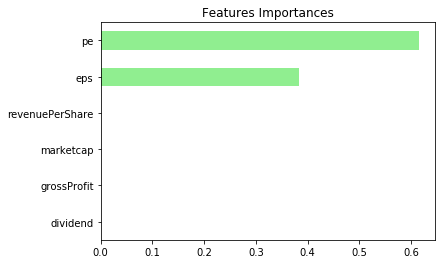

In [70]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train)

# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()


Things to consider: 
    stocks will tend to be correlated with each other